In [60]:
import torch
import torch.nn as nn
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm
import quantecon as qe

# Set device - use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Model Parameters

In [61]:
# Preferences
beta = 0.9      # Discount factor
gamma = 2.0     # Risk aversion (CRRA)
r = (1/beta-1) * 0.9

# Income process (log-AR(1))
rho_Z = 0.9       # Persistence
sigma_Z = 0.2     # Shock standard deviation
mu_Z = np.exp(1/2 * sigma_Z**2 / (1 - rho_Z**2))

nA = 1000
Amin = 0.0
Amax = 10.0
A_grid = np.linspace(Amin, Amax, nA)

In [62]:
def coh_fun(Z, A):
    return A * (1+r) + Z

def c_fun(savings_rate, Z, A):
    """Consumption function given savings rate, TFP Z and assets A"""
    coh = coh_fun(Z, A)
    return (1 - savings_rate) * coh

In [63]:
class DecisionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), # two inputs 
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1) # one output
        )
        # Initialize with He uniform (similar to TensorFlow's he_uniform)
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)
        
    def forward(self, x):
        return self.net(x)


network = DecisionNetwork().to(device)

In [64]:
def policy_function(Z, A):
    """Decision rule: maps states to savings rate"""
    
    # Normalize inputs to roughly [-1, 1] range
    Z_normalized = (Z-mu_Z) / sigma_Z / 2
    A_normalized = 2.0 * (A - Amin) / (Amax - Amin) - 1.0
    
    # Stack inputs: shape (n, 2)
    s = torch.stack([Z_normalized, A_normalized], dim=1)
    
    # Forward pass through network
    x = network(s)  # (n, 1)
    
    # Savings rate in [0,1]
    savings_rate = torch.sigmoid(x[:, 0])
    
    return torch.clamp(savings_rate, max=0.999)

In [65]:
# Here is the Fischer-Burmeister (FB) in PyTorch:
min_FB = lambda a,b: a+b-torch.sqrt(a**2+b**2)

def euler_residuals(Z, A, eps):
    # Current decisions
    savings_rate = policy_function(Z, A)
    coh = coh_fun(Z, A)
    A_next = savings_rate * coh

    # Clamp A_next to valid asset range
    A_next = torch.clamp(A_next, min=Amin, max=Amax)

    C = coh - A_next

    # Compute Z' in levels: Z' = exp(rho * log Z + eps)
    logZ = torch.log(Z)
    logZ_next = rho_Z * logZ.unsqueeze(0) + eps
    Z_next = torch.exp(logZ_next)

    # Next-period policy and consumption (vectorized over shocks)
    A_next_rep = A_next.unsqueeze(0).expand_as(Z_next)
    savings_rate_next = policy_function(Z_next.reshape(-1), A_next_rep.reshape(-1)).reshape_as(Z_next)
    C_next = c_fun(savings_rate_next, Z_next, A_next_rep)

    # Future returns and marginal utility (Monte Carlo expectation)
    MU_next = C_next**(-gamma)
    EMU_next = MU_next.mean(dim=0)
    RHS = beta * EMU_next * (1.0 + r) 
    
    # Residual
    FOC = RHS**(-1/gamma) / C - 1.0
    R = min_FB(FOC, savings_rate)
    return R

## Objective Function 

In [66]:
def sample_Z_ergodic(n, rho, sigma_eps, *, device=None, dtype=torch.float32):
    if not (-1.0 < rho < 1.0):
        raise ValueError("Need |rho| < 1 for a stationary (ergodic) distribution.")
    device = device or torch.device("cpu")
    rho = torch.as_tensor(rho, device=device, dtype=dtype)
    sigma_eps = torch.as_tensor(sigma_eps, device=device, dtype=dtype)

    sigma_x = sigma_eps / torch.sqrt(1.0 - rho**2)          # std of log Z in stationarity
    x = sigma_x * torch.randn(n, device=device, dtype=dtype) # mean 0
    Z = torch.exp(x)
    return Z

def objective_function(n, n_shocks= 64):

    # Sample current states from ergodic distribution
    Z = sample_Z_ergodic(n, rho_Z, sigma_Z, device=device)
    A = torch.rand(n, device=device) * (Amax - Amin) + Amin

    # Monte Carlo expectation with n_shocks draws per state
    eps = sigma_Z * torch.randn(n_shocks, n, device=device)
    R = euler_residuals(Z, A, eps)
    return torch.mean(R**2)

In [67]:
base_lr = 1e-5
target_lr = 1e-3
warmup_steps = 5_000

optimizer = torch.optim.Adam(network.parameters(), lr=base_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: 1.0 + (target_lr / base_lr - 1.0) * min(1.0, (step + 1) / warmup_steps),
)

n = 128

def training_step():
    optimizer.zero_grad()
    loss = objective_function(n)  
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

def train(K):
    vals = []
    for k in tqdm(range(K)):
        val = training_step()
        vals.append(val)
    return vals

In [68]:
results = train(100_000)

100%|██████████| 100000/100000 [1:29:05<00:00, 18.71it/s]  


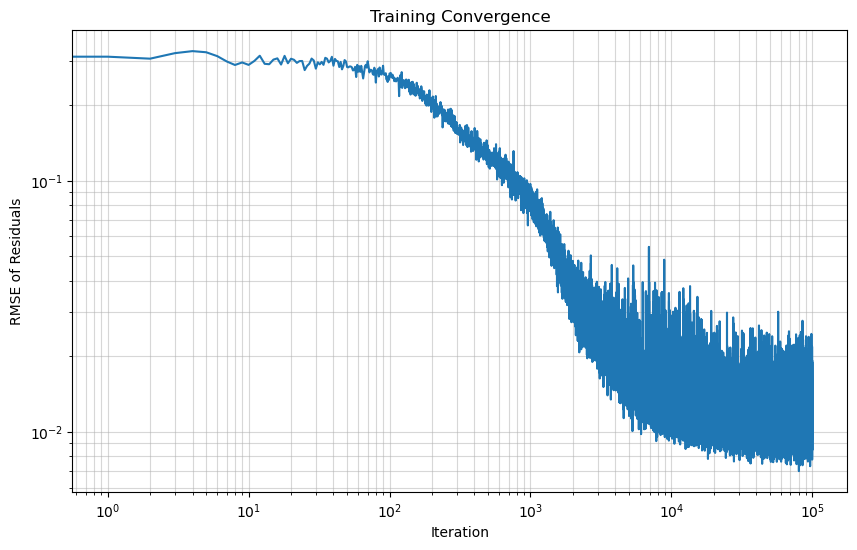

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(np.abs(results)))  # abs() for numerical safety
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('RMSE of Residuals')
plt.title('Training Convergence')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

## Learned Decision Rule

In [70]:
from consav_vfi import vfi, A_grid as A_grid_vfi

_, policy_A = vfi(tol = 1e-6, max_iter = 1000, verbose = True)

Iteration 1: max value function diff = 4.70548503
Iteration 2: max value function diff = 3.12203704
Iteration 3: max value function diff = 2.17528631
Iteration 4: max value function diff = 1.56281993
Iteration 5: max value function diff = 1.14606327
Iteration 6: max value function diff = 0.85359968
Iteration 7: max value function diff = 0.64353004
Iteration 8: max value function diff = 0.48996689
Iteration 9: max value function diff = 0.37621921
Iteration 10: max value function diff = 0.29105143
Iteration 11: max value function diff = 0.22668934
Iteration 12: max value function diff = 0.17766449
Iteration 13: max value function diff = 0.14006549
Iteration 14: max value function diff = 0.11104843
Iteration 15: max value function diff = 0.08852366
Iteration 16: max value function diff = 0.07094194
Iteration 17: max value function diff = 0.05714806
Iteration 18: max value function diff = 0.04627008
Iteration 19: max value function diff = 0.03765001
Iteration 20: max value function diff = 

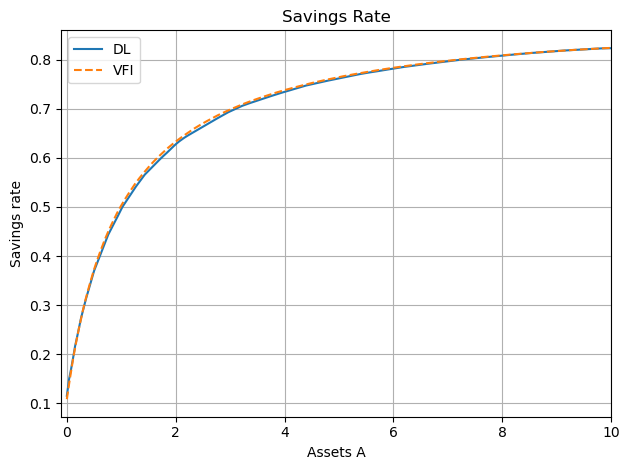

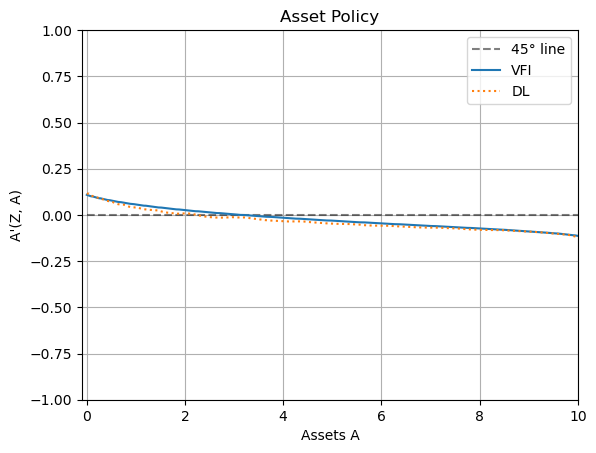

In [71]:
with torch.no_grad():
    A_grid = torch.tensor(A_grid, dtype=torch.float32, device=device)
    ones = torch.ones_like(A_grid)  # Z = 1 (level value at steady state)
    savings_rate_vec = policy_function(ones, A_grid)

# VFI savings rate for a representative Z index
coh_vfi = A_grid * (1 + r) + 1.0 
savings_rate_vfi = policy_A[4, :] / coh_vfi

plt.plot(A_grid.cpu(), savings_rate_vec.cpu(), label='DL')
plt.plot(A_grid, savings_rate_vfi, linestyle='--', label='VFI')
plt.xlabel("Assets A")
plt.ylabel("Savings rate")
plt.title("Savings Rate")
plt.xlim(-0.1, Amax)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

coh = coh_fun(ones, A_grid)
A_next_dl = savings_rate_vec * coh
A_next_vfi = policy_A[4, :]

plt.plot(A_grid.cpu(), np.zeros_like(A_grid.cpu()), 'k--', alpha=0.5, label='45° line')
plt.plot(A_grid_vfi, A_next_vfi - A_grid_vfi, label='VFI')
plt.plot(A_grid.cpu(), A_next_dl.cpu() - A_grid.cpu(), label='DL', linestyle=':')
plt.xlabel('Assets A')
plt.ylabel("A'(Z, A)")
plt.title('Asset Policy')
plt.xlim(-0.1, Amax)
plt.ylim(-1, 1)
plt.legend()
plt.grid()
plt.show()